Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [48]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
       'ShortPassing',  'Dribbling',  
        'BallControl',  'SprintSpeed', 
       'Reactions',    'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision'
]
# PLAYER_ATTRIBUTES = [ 'shooting','ShortPassing','Dribbling','BallControl',
#                      'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']
# PLAYER_ATTRIBUTES = [ 'Finishing',   'LongShots','ShotPower',   'Volleys',   'FKAccuracy',  'HeadingAccuracy',
#                       'Positioning', 'Vision' ,'ShortPassing','LongPassing',
#                      'BallControl','Dribbling', 
#                       'Acceleration', 'SprintSpeed', 'Agility','Reactions', 
#                       'Balance', 'Stamina','Jumping','Composure']


In [49]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [50]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [51]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,17.523810,31.885362,-3.760141,29.676896,2.948854,30.643264,27.901235,36.698413,27.425044,32.679949
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,13.694268,28.792994,9.729299,32.084076,11.869427,28.774510,15.082803,34.920382,26.222930,32.980392
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,12.880616,20.573813,8.230424,16.210783,9.536585,17.108108,15.676508,21.075738,15.767651,15.738739
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,14.954751,19.935520,2.419118,19.206109,9.916290,23.765370,23.869910,24.214932,20.031674,22.041824
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,14.954751,19.935520,0.419118,20.606109,16.916290,26.765370,12.869910,26.214932,14.031674,26.708490


# 

In [52]:
df_raw.Positioning

ID      Name               FIFA
158023  L. Messi           2011    90.0
20801   Cristiano Ronaldo  2011    88.0
244778  Trincão            2021    74.0
183277  E. Hazard          2011    80.0
243812  Rodrygo            2021    83.0
                                   ... 
20486   Carlinhos Bala     2011    64.0
193268  A. Gerbo           2011    60.0
189437  C. Pasquato        2011    60.0
135499  Dagoberto          2011    74.0
1551    L. Giuly           2011    71.0
Name: Positioning, Length: 6474, dtype: float64

In [53]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [54]:
df = df[df.winger == 0]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
75.0    28
78.0    27
77.0    24
74.0    24
73.0    22
76.0    19
70.0    16
72.0    15
69.0    15
81.0    12
84.0    12
79.0    12
80.0    11
71.0    10
67.0     9
82.0     9
83.0     9
68.0     8
64.0     6
66.0     6
87.0     4
88.0     4
89.0     3
86.0     2
63.0     2
65.0     2
91.0     1
85.0     1
90.0     1
92.0     1
61.0     1
57.0     1
62.0     1
Name: count, dtype: int64


In [55]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,drop,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,72.0,72.0,drop,ST
253002,G. Raspadori,2022,21.0,21.0,22.0,88.0,88.0,74.0,79.0,79.0,valid,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,25.0,88.0,88.0,76.0,84.0,84.0,train,ST


In [56]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [57]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'Att. Position',
       'mental'],
      dtype='object')

#### Transform Value

In [58]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

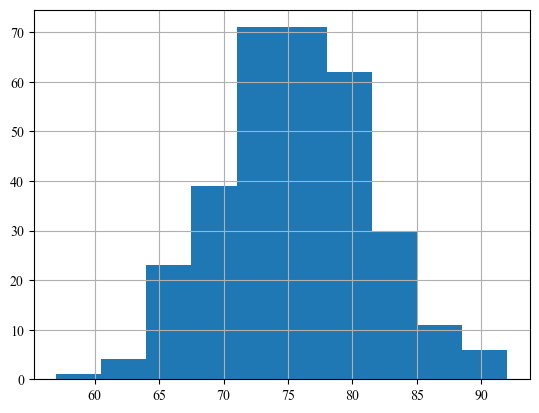

In [59]:
df['target'].hist()

In [ ]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [ ]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'Att. Position', 'max_potential', 'prime_age',
       'PrimeOverall', 'best_position', 'central', 'winger', 'offense',
       'Defense', 'overall_age_ratio', 'youth_player', 'shooting',
       'shooting_technique', 'mental', 'physique', 'Speed', 'ball_handling',
       'age_based_Strength',

In [ ]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [ ]:
y_train.describe()

count    156.000000
mean      75.878205
std        5.538537
min       57.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       89.000000
Name: target, dtype: float64

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [ ]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


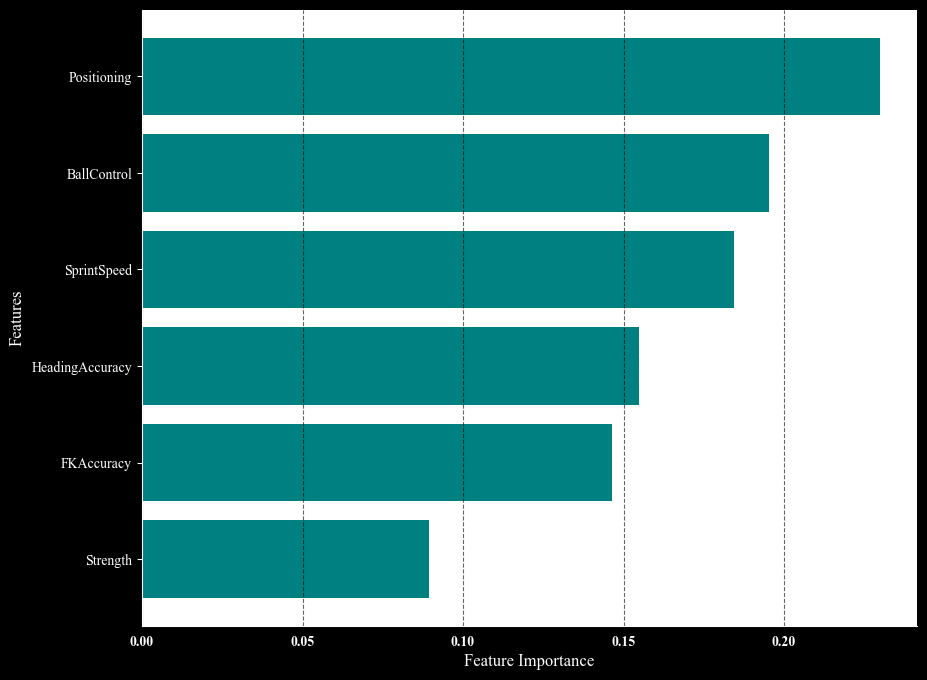

100%|██████████| 30/30 [00:01<00:00, 18.47it/s]


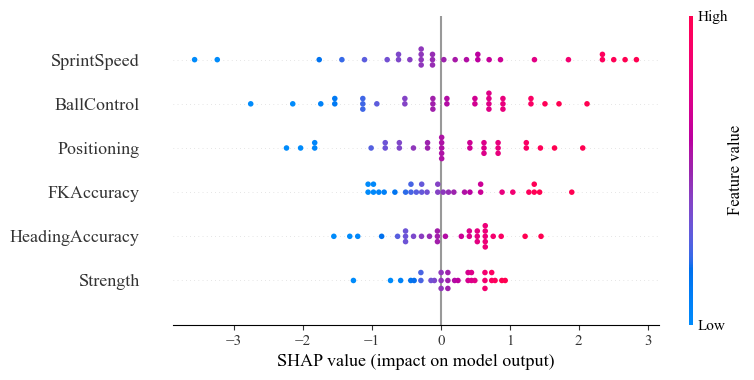

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Huber Regression training----->


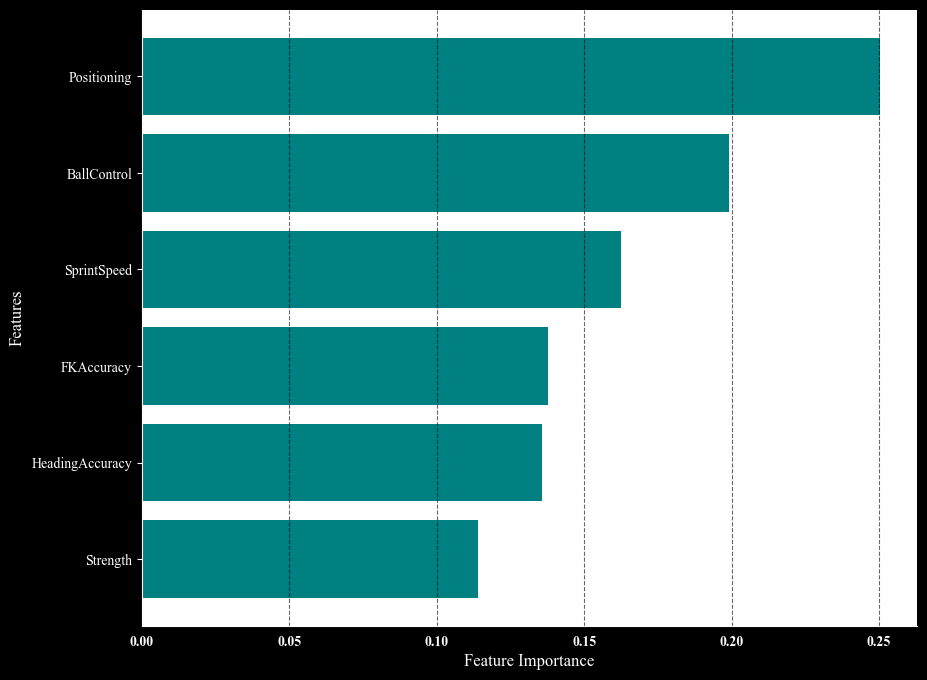

100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


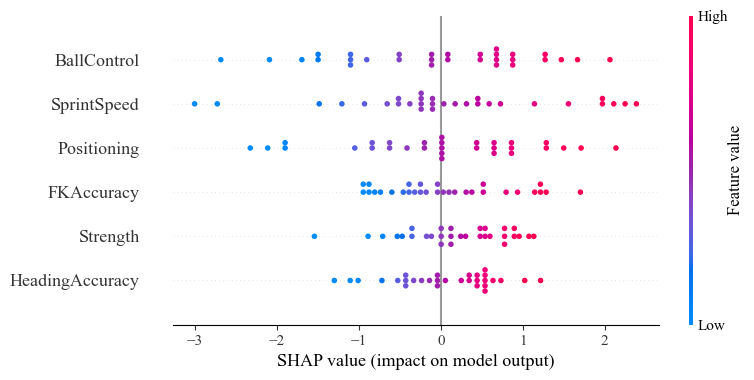

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Linear Regression training----->


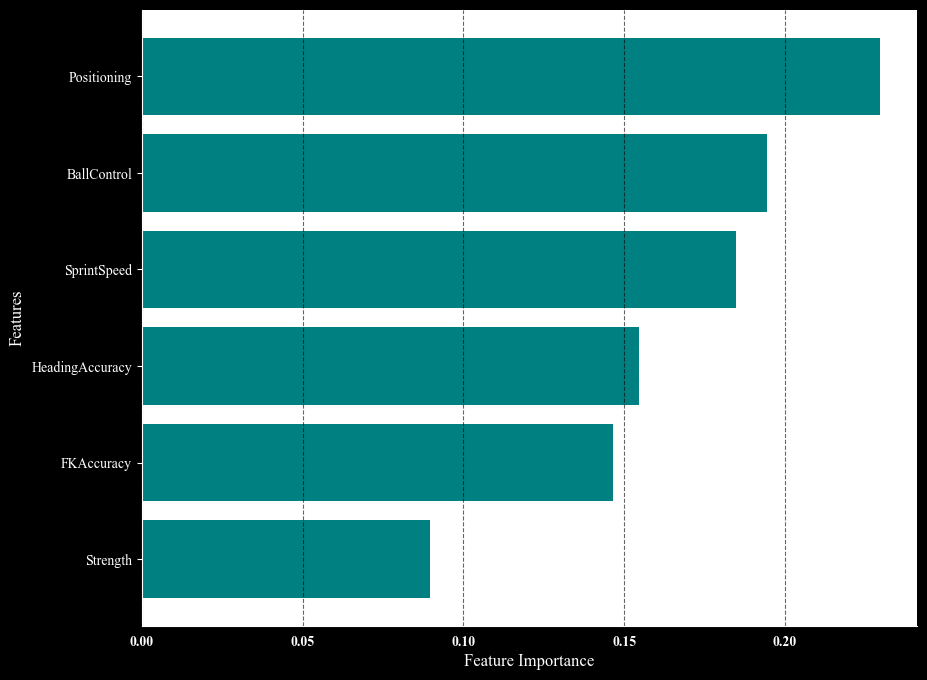

100%|██████████| 30/30 [00:01<00:00, 27.27it/s]


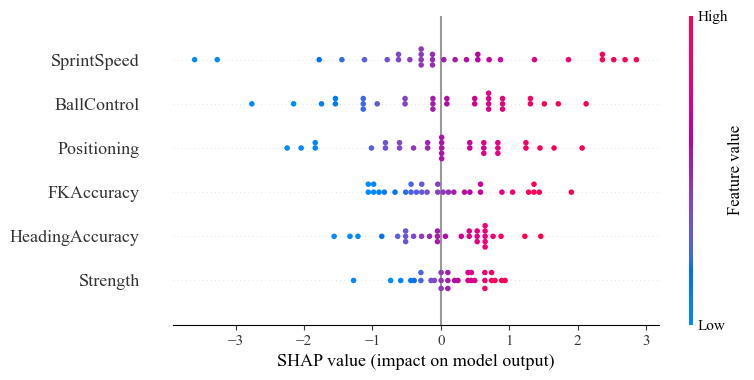

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        54
        True       0.20      0.20      0.20         5

    accuracy                           0.86        59
   macro avg       0.56      0.56      0.56        59
weighted avg       0.86      0.86      0.86        59

Model: Ridge Regression
Mean Squared Error: 16.76
Mean Absolute Error: 3.32
R2 Score: 0.44

Model: Huber Regression
Mean Squared Error: 16.27
Mean Absolute Error: 3.26
R2 Score: 0.46

Model: Linear Regression
Mean Squared Error: 16.77
Mean Absolute Error: 3.32
R2 Score: 0.44



In [ ]:
from sklearn.linear_model import LinearRegression,HuberRegressor

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.model.prepare import select_features
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [ ]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [ ]:
X_train.describe()

,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,46.660256,62.750000,61.519231,69.435897,69.583333,77.717949,65.352564,64.435897,61.615385,48.269231,68.230769,58.256410
std,12.690101,9.007971,8.032572,7.680877,6.463753,7.553504,7.973994,12.299058,7.527551,13.767351,7.564643,9.349053
min,22.000000,33.000000,41.000000,47.000000,51.000000,55.000000,45.000000,27.000000,42.000000,26.000000,51.000000,34.000000
25%,37.000000,58.000000,56.000000,64.000000,65.750000,74.000000,59.000000,57.750000,56.000000,35.000000,62.000000,52.000000
50%,43.000000,63.000000,61.000000,70.000000,70.000000,77.000000,66.000000,65.000000,61.500000,48.000000,68.000000,58.500000
75%,56.000000,69.000000,67.000000,75.000000,74.000000,83.250000,71.000000,74.000000,67.000000,58.000000,74.000000,64.000000
max,75.000000,83.000000,81.000000,87.000000,87.000000,92.000000,86.000000,91.000000,82.000000,79.000000,86.000000,82.000000


In [ ]:
y_test.describe()

count    59.000000
mean     73.423729
std       5.537345
min      63.000000
25%      69.000000
50%      72.000000
75%      77.500000
max      91.000000
Name: target, dtype: float64

In [ ]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [ ]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

59

<Axes: >

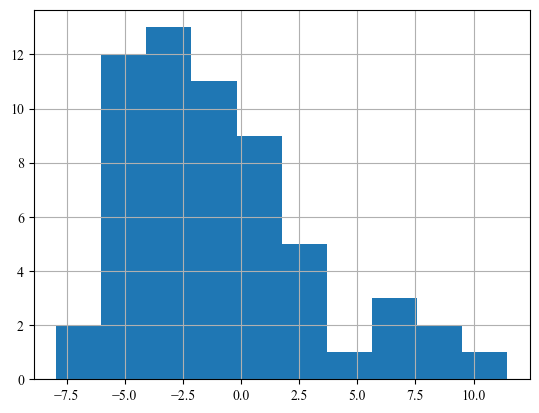

In [ ]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

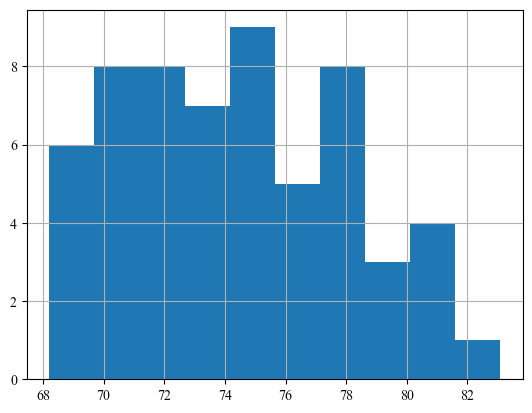

In [ ]:
result_df.sort_values(ascending=False).hist()

In [ ]:
(y_test-result_df).describe()

count    59.000000
mean     -0.891814
std       3.968063
min      -7.956372
25%      -3.852985
50%      -1.851291
75%       0.715569
max      11.440159
dtype: float64

In [ ]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,FKAccuracy,HeadingAccuracy,ShortPassing,Dribbling,BallControl,SprintSpeed,Reactions,Strength,LongShots,Aggression,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,
251852,K. Adeyemi,2021,59.0,62.0,67.0,75.0,73.0,88.0,63.0,56.0,69.0,36.0,63.0,66.0
241721,Rafael Leão,2020,58.0,58.0,67.0,77.0,75.0,86.0,73.0,77.0,62.0,59.0,78.0,69.0
246191,J. Álvarez,2020,66.0,60.0,63.0,68.0,72.0,78.0,66.0,40.0,59.0,32.0,65.0,60.0
239085,E. Håland,2020,51.0,62.0,67.0,72.0,74.0,83.0,72.0,84.0,62.0,81.0,73.0,57.0
256853,M. Tillman,2021,32.0,59.0,57.0,62.0,62.0,65.0,54.0,59.0,59.0,41.0,57.0,53.0
246430,D. Vlahović,2021,37.0,68.0,60.0,70.0,72.0,66.0,68.0,68.0,64.0,50.0,74.0,54.0
238616,Pedro Neto,2020,40.0,51.0,60.0,70.0,71.0,78.0,65.0,40.0,62.0,32.0,64.0,56.0
252324,Riquelme,2020,44.0,46.0,62.0,63.0,64.0,64.0,62.0,47.0,59.0,58.0,65.0,61.0


In [ ]:
y_test[outlier]

ID      Name         FIFA
251852  K. Adeyemi   2021    80.0
241721  Rafael Leão  2020    86.0
246191  J. Álvarez   2020    81.0
239085  E. Håland    2020    91.0
256853  M. Tillman   2021    74.0
246430  D. Vlahović  2021    84.0
238616  Pedro Neto   2020    78.0
252324  Riquelme     2020    78.0
Name: target, dtype: float64

In [ ]:
result_df[outlier]

ID      Name         FIFA
251852  K. Adeyemi   2021    76.821180
241721  Rafael Leão  2020    80.919117
246191  J. Álvarez   2020    75.009077
239085  E. Håland    2020    79.559841
256853  M. Tillman   2021    68.197263
246430  D. Vlahović  2021    75.680253
238616  Pedro Neto   2020    71.915124
252324  Riquelme     2020    69.019033
dtype: float64

In [ ]:
(y_test/result_df).describe()

count    59.000000
mean      0.987890
std       0.053414
min       0.889428
25%       0.950665
50%       0.973598
75%       1.009695
max       1.143793
dtype: float64

In [ ]:
(y_test/result_df).describe()

count    59.000000
mean      0.987890
std       0.053414
min       0.889428
25%       0.950665
50%       0.973598
75%       1.009695
max       1.143793
dtype: float64

In [ ]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.69806696],
       [0.69806696, 1.        ]])

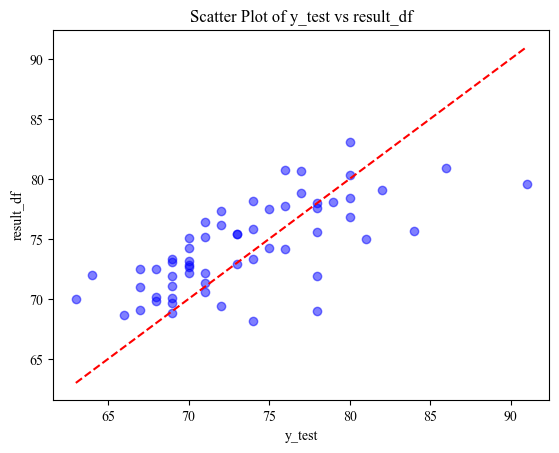

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [ ]:
result_df = result_df.sort_values(ascending=False)

In [ ]:
result_df.head(50)

ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.089586
241721  Rafael Leão       2020    80.919117
245158  L. Suárez         2021    80.739262
235866  C. Kouamé         2020    80.682099
231447  D. Malen          2020    80.351486
239085  E. Håland         2020    79.559841
253072  D. Núñez          2021    79.042788
241522  J. Wind           2021    78.851291
246186  Arthur Cabral     2021    78.377708
233732  D. Okereke        2020    78.144137
243630  J. David          2020    78.052566
251470  C. De Ketelaere   2021    78.028600
244797  P. Musa           2021    77.740398
244622  Puado             2020    77.554779
245940  S. Wamangituka    2020    77.499749
251756  R. Nteka          2021    77.308651
251852  K. Adeyemi        2021    76.821180
245396  V. Supryaga       2021    76.438430
225668  K. Grant          2020    76.163151
252042  João Pedro        2021    75.814300
246430  D. Vlahović       2021    75.680253
246147  M. Greenwood      2020    75.615184
2

In [ ]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.089586
241721  Rafael Leão       2020    80.919117
231447  D. Malen          2020    80.351486
dtype: float64

In [ ]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

6


ID      Name           FIFA
239085  E. Håland      2020    79.559841
253072  D. Núñez       2021    79.042788
246186  Arthur Cabral  2021    78.377708
251852  K. Adeyemi     2021    76.821180
246430  D. Vlahović    2021    75.680253
246191  J. Álvarez     2020    75.009077
dtype: float64

In [ ]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

4


ID      Name              FIFA
221479  D. Calvert-Lewin  2020    83.089586
245158  L. Suárez         2021    80.739262
235866  C. Kouamé         2020    80.682099
231447  D. Malen          2020    80.351486
dtype: float64

In [ ]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

48


ID      Name             FIFA
246728  L. Traoré        2020    73.323004
241487  J. Ferreira      2020    74.158163
238900  E. Demirović     2021    74.245858
252037  Fábio Silva      2020    74.280525
247888  S. Esposito      2021    75.106888
251105  D. Joveljić      2020    75.171292
243315  Dani Gómez       2020    75.382991
239025  I. Niane         2020    75.418544
246147  M. Greenwood     2020    75.615184
252042  João Pedro       2021    75.814300
225668  K. Grant         2020    76.163151
245396  V. Supryaga      2021    76.438430
251756  R. Nteka         2021    77.308651
245940  S. Wamangituka   2020    77.499749
244622  Puado            2020    77.554779
244797  P. Musa          2021    77.740398
251470  C. De Ketelaere  2021    78.028600
243630  J. David         2020    78.052566
233732  D. Okereke       2020    78.144137
241522  J. Wind          2021    78.851291
dtype: float64

In [ ]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.72      0.59      0.65        39
        True       0.41      0.55      0.47        20

    accuracy                           0.58        59
   macro avg       0.56      0.57      0.56        59
weighted avg       0.61      0.58      0.59        59

